In [2]:
import pandas as pd
import operator


from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import RidgeClassifier, Ridge, ElasticNet, BayesianRidge, LassoLars, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from boruta import BorutaPy

%pylab inline

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


http://srisai85.github.io/airfoil_noise/Airfoil_Noise_Prediction.html#/

In [3]:
raw_data = pd.read_csv("airfoil_self_noise.dat.txt", sep="\t", header=None)

The NASA data set comprises different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. The span of the airfoil and the observer position were the same in all of the experiments.

In [ ]:
http://airfoiltools.com/airfoil/details?airfoil=n0012-il

This problem has the following inputs: 
1. Frequency, in Hertzs. 
2. Angle of attack, in degrees. 
3. Chord length, in meters. 
4. Free-stream velocity, in meters per second. 
5. Suction side displacement thickness, in meters. 

The only output is: 
6. Scaled sound pressure level, in decibels. 

In [4]:
data = raw_data.rename(index=str, columns={0: "Freq", 1: "Angle_attack", 
                                               2: "Chord_length", 3: "Velocity", 4: "Disp_thick", 5: "Pres_level"})

In [5]:
data.head()

,Freq,Angle_attack,Chord_length,Velocity,Disp_thick,Pres_level
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [6]:
import lightgbm as lgb
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV

In [7]:
nu = 15.68e-06 # Kinematic Viscosity for air at 300K (27°C) is noted as 1.568e-5
c0 = 1450
data["Re"] = data["Velocity"]*data["Chord_length"]/nu # Re = Free Stream Velocity * Characteristic Length/Kinematic Viscosity
data["St"] = data["Freq"]*data["Disp_thick"]/data["Velocity"]
data["Stl"] = data["Freq"]*data["Chord_length"]/data["Velocity"]
data["Delta"] = data["Disp_thick"]/data["Chord_length"]
data["Ro"] = data["Re"]*data["St"]
data["Ma"] = data["Velocity"]/c0
data["Alpha"] = data["Angle_attack"]

In [8]:
data.columns

Index(['Freq', 'Angle_attack', 'Chord_length', 'Velocity', 'Disp_thick',
       'Pres_level', 'Re', 'St', 'Stl', 'Delta', 'Ro', 'Ma', 'Alpha'],
      dtype='object')

In [122]:
y = data['Pres_level']
X = data[['St', 'Stl', 'Ro', 'Alpha', 'Delta', 'Re', 'Ma']]     
#X = data[['St', 'An', 'Dt', 'Re', 'Ma', 'Freq', 'Angle_attack', 'Chord_length', 'Disp_thick']]

In [123]:
X["St*Alp"] = data["St"]*data["Alpha"]
X["St*rDel"] = data["St"]*np.power(data["Delta"],-1/2)

### Models

In [124]:
def data_preprocess(data):
    final_data = data.copy()
    
    #poly = PolynomialFeatures()
    #final_data = poly.fit_transform(final_data)
    
    return final_data

In [125]:
seed=48
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.2)

In [126]:
features = data_preprocess(X_train)
train_feat = features
train_labels = y_train

In [127]:
print(sum(y_train), sum(y_test))

150060.65500000003 37567.767


In [128]:
def show_cv(clf_i, name, f, l, cv, score='r2', param=None, vbs=False):
    if param: 
        grid_cv = GridSearchCV(
            clf_i,
            param,
            scoring=score,
            cv=cv,
            verbose=vbs,
            n_jobs=-1
        )
        grid_cv.fit(f, l)
        clf_i = grid_cv.best_estimator_
        print(grid_cv.best_params_)
    score = cross_val_score(clf_i,f,l,cv=cv, scoring=score, n_jobs=-1)
    print(name, score.mean(), score.std(), score.min(), score.max())

In [129]:
np.random.seed(seed)

In [130]:
scaler = StandardScaler()
model_rc = Ridge()
model_bay = BayesianRidge()
model_lars = LassoLars()
model_knn = KNeighborsRegressor()
model_svr = LinearSVR()
model_radsvr = SVR()
model_t = DecisionTreeRegressor()
model_rf = RandomForestRegressor()
model_gb = XGBRegressor()
model_mlp = MLPRegressor()
pipeline_rc = make_pipeline(scaler, model_rc)
pipeline_svr = make_pipeline(scaler, model_svr)
pipeline_bay = make_pipeline(scaler, model_bay)
pipeline_lars = make_pipeline(scaler, model_lars)
pipeline_radsvr = make_pipeline(scaler, model_radsvr)
pipeline_knn = make_pipeline(scaler, model_knn)
pipeline_mlp = make_pipeline(scaler, model_mlp)


clfs = [
    ['Ridge',pipeline_rc],
    ['KNN', pipeline_knn],
    ['LAR', pipeline_lars],
    ['BR', pipeline_bay], 
    ['SVR L', pipeline_svr],
    ['SVR NL', pipeline_radsvr],
    ['DT', model_t],
    ['RF', model_rf],
    ['GB', model_gb],
    ['MLP', pipeline_mlp]
]

cv = KFold(n_splits=10, shuffle=True, random_state=seed).get_n_splits(train_feat,train_labels)
for name, cl in clfs:
    show_cv(cl, name, train_feat, train_labels, cv)

Ridge 0.6252124821194052 0.05494152728000221 0.5251080580284238 0.7167066977234011
KNN 0.8052424404261671 0.026152841774382356 0.7577360799174162 0.8427361848684669
LAR -0.011016190409286475 0.01402557933378859 -0.04683987195016903 -1.489633076956487e-05
BR 0.6231084030252494 0.053365781730253685 0.5250377373088053 0.7133607202580925
SVR L 0.610754756295299 0.05939249381983265 0.5279320254023692 0.7159984825647885
SVR NL 0.7083395492631654 0.056839498877178644 0.613073572496949 0.7722694822607423
DT 0.8097257172080286 0.03288173076316468 0.7611567540691268 0.8547310909688253
RF 0.8909662409632721 0.025960456550936508 0.8318919890904514 0.9241820928102993
GB 0.8887371817520691 0.024210631929671763 0.8424283624262813 0.9212447551514197
MLP -9.746539843907348 2.461141189417559 -13.495483112085212 -6.713678334037453


In [18]:
clfs = [
    ['Ridge',pipeline_rc],
    ['KNN', pipeline_knn],
    ['LAR', pipeline_lars], 
    ['BR', pipeline_bay], 
    ['SVR L', pipeline_svr],
    ['SVR NL', pipeline_radsvr],
    ['DT', model_t],
    ['RF', model_rf],
    ['GB', model_gb],
    ['MLP', pipeline_mlp]
]

parameters={
    
    'Ridge': {
        'ridge__alpha': np.linspace(0.001, 100, num=20)
    },
    
    'KNN': {
        'kneighborsregressor__n_neighbors': np.arange(3, 15, 1),
        'kneighborsregressor__weights': ['uniform','distance']
    },
    
      'LAR': {
        'lassolars__max_iter': [500,1000],
        'lassolars__alpha': np.linspace(0.001, 100, num=20)
    },
   
    'BR': {
        'bayesianridge__alpha_1': [1e-06,0.01,1.0,10,100],
        'bayesianridge__alpha_2': [1e-06,0.01,1.0,10,100],
        'bayesianridge__lambda_1': [1e-06,0.01,1.0,10,100],
        'bayesianridge__lambda_2': [1e-06,0.01,1.0,10,100]
    },
   
    'SVR L': {
        'linearsvr__C': np.linspace(0.001, 100, num=20),
        'linearsvr__epsilon': [0.0,0.05,0.1]
    },
    
      'SVR NL': {
        'svr__C': np.linspace(0.001,100,num=10),
        'svr__epsilon': [0,0.05,0.1],
        'svr__kernel': ['poly','rbf'],
        'svr__degree': [2,3]
    },
    
    'DT': {
        'max_depth': [6,8,10,12,15],
        'max_features': [0.3,0.5,0.7,0.9,1.0],
        'min_samples_split': [2,5,10],
        'min_samples_leaf': [2,5,10]
    },
        
    'RF': {
        'n_estimators': [50, 100, 200, 300, 500],
        'max_depth': [8,10,12,15,18],
        'min_samples_split': [2,5,10],
        'min_samples_leaf': [2,5,10],
    },
    'GB': {
        'n_estimators': [20, 50, 60, 75, 100, 200],
        'learning_rate': np.linspace(0.001, 0.5, num=20),
        'max_depth': [3,5,7]
    },

    'MLP': {
        'mlpregressor__hidden_layer_sizes': [(20,), (50,), (100,)],
        'mlpregressor__activation': ['relu','logistic'],
    }
}

for name, cl in clfs:
    show_cv(cl, name, train_feat, train_labels, cv, param=parameters.get(name), vbs=True)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s


{'ridge__alpha': 0.001}


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.6s finished


Ridge 0.6253310539093209 0.05659997207625592 0.5241008947977231 0.717991678194484
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s


{'kneighborsregressor__n_neighbors': 3, 'kneighborsregressor__weights': 'distance'}


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.7s finished


KNN 0.8740660048499349 0.02668231285411381 0.829213254156937 0.9186733106580937
Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s


{'lassolars__alpha': 0.001, 'lassolars__max_iter': 500}


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished


LAR 0.6220507986228168 0.05127105075860647 0.5247011956410591 0.7102017435610997
Fitting 10 folds for each of 625 candidates, totalling 6250 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 1480 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 2380 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 3480 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 4780 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6250 out of 6250 | elapsed:  1.5min finished


{'bayesianridge__alpha_1': 100, 'bayesianridge__alpha_2': 1e-06, 'bayesianridge__lambda_1': 1e-06, 'bayesianridge__lambda_2': 100}
BR 0.625254778050462 0.0557670997081421 0.524707366004699 0.717412588288906
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    6.6s finished


{'linearsvr__C': 68.42136842105263, 'linearsvr__epsilon': 0.0}
SVR L 0.6102943587155678 0.06154513433021939 0.49950080379294626 0.6809366068642084
Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 609 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 959 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.7min finished


{'svr__C': 100.0, 'svr__degree': 2, 'svr__epsilon': 0.1, 'svr__kernel': 'rbf'}
SVR NL 0.8238616987225257 0.04582716551947694 0.7597791301140876 0.8826697687454209
Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:    2.6s finished


{'max_depth': 12, 'max_features': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 10}
DT 0.8156664421627934 0.03503904089749287 0.7609087215595449 0.8687731545318018
Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:  2.0min finished


{'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
RF 0.900053304214353 0.021352671083625135 0.8580710795274105 0.9259640088226895
Fitting 10 folds for each of 360 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2632 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:   17.6s finished


{'learning_rate': 0.07978947368421052, 'max_depth': 7, 'n_estimators': 200}
GB 0.938230142357787 0.015977060942814852 0.9060735721989019 0.9587512520848585
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.3min finished


{'mlpregressor__activation': 'relu', 'mlpregressor__hidden_layer_sizes': (100,)}
MLP -9.950864886652127 2.2787205206414436 -12.895471838454458 -6.484279809300593


Best: 0.926690 using {'learning_rate': 0.1, 'n_estimators': 500}
-147.874393 (19.736263) with: {'learning_rate': 0.02, 'n_estimators': 20}
-98.607368 (13.260340) with: {'learning_rate': 0.02, 'n_estimators': 30}
-65.675673 (8.913718) with: {'learning_rate': 0.02, 'n_estimators': 40}
-5.185959 (0.852970) with: {'learning_rate': 0.02, 'n_estimators': 100}
0.725078 (0.057328) with: {'learning_rate': 0.02, 'n_estimators': 200}
0.860154 (0.033741) with: {'learning_rate': 0.02, 'n_estimators': 300}
0.877293 (0.027806) with: {'learning_rate': 0.02, 'n_estimators': 400}
0.887460 (0.023489) with: {'learning_rate': 0.02, 'n_estimators': 500}
-42.310085 (5.813225) with: {'learning_rate': 0.05, 'n_estimators': 20}
-14.759156 (2.144239) with: {'learning_rate': 0.05, 'n_estimators': 30}
-4.825047 (0.802667) with: {'learning_rate': 0.05, 'n_estimators': 40}
0.839386 (0.040613) with: {'learning_rate': 0.05, 'n_estimators': 100}
0.888127 (0.025161) with: {'learning_rate': 0.05, 'n_estimators': 200}
0.9

Text(0,0.5,'R2')

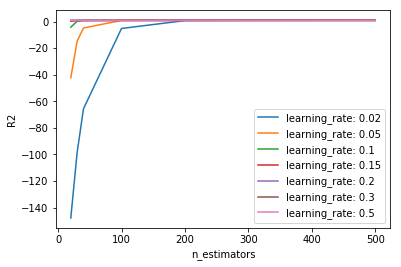

In [20]:
model = XGBRegressor()
 
n_estimators = [20, 30, 40, 100, 200, 300, 400, 500]
learning_rate = [0.02, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5] 

param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

grid_search = GridSearchCV(model, param_grid, scoring="r2", cv=cv, n_jobs=-1)
grid_result = grid_search.fit(train_feat, train_labels)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    pyplot.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('R2')

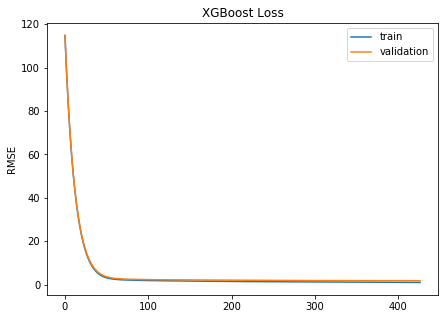

In [26]:
model = XGBRegressor(n_estimators=1000, learning_rate=0.079)

est_feat, valid_feat, est_labels, valid_labels = train_test_split(train_feat, train_labels, test_size=0.1, random_state=seed)
eval_set = [(est_feat, est_labels), (valid_feat, valid_labels)]
model.fit(est_feat, est_labels, eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=10, verbose=False)
# make predictions for test data
y_pred = model.predict(valid_feat)
predictions = [round(value) for value in y_pred]
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig = plt.figure(figsize=(7,5))
plt.plot(x_axis, results['validation_0']['rmse'], label='train')
plt.plot(x_axis, results['validation_1']['rmse'], label='validation')
plt.legend()
#plt.ylim([0,20])
plt.ylabel('RMSE')
plt.title('XGBoost Loss')
plt.show()

In [45]:
import numpy as np
import pandas as pd

from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin

In [46]:
scorer = make_scorer(r2_score, greater_is_better=True)

In [48]:
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': float(params['learning_rate']),
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_weight': int(params['min_child_weight']),
        'reg_alpha': float(params['reg_alpha'])
    }
    
    clf = XGBRegressor(
        n_jobs=6,
        **params
    )
    
    score = cross_val_score(clf, train_feat, train_labels, scoring=scorer, cv=cv).mean()
    print("R2 {:.3f} params {}".format(score, params))
    if score < 0:
        score=0
    return -score

space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 100),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 9, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 1e-5, 100)
}

trials=Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=300)

R2 0.883 params {'n_estimators': 250, 'learning_rate': 0.2900875296924542, 'max_depth': 8, 'gamma': '0.128', 'colsample_bytree': '0.616', 'min_child_weight': 6, 'reg_alpha': 43.774502676041486}
R2 0.892 params {'n_estimators': 250, 'learning_rate': 0.16957253416429757, 'max_depth': 6, 'gamma': '0.490', 'colsample_bytree': '0.492', 'min_child_weight': 4, 'reg_alpha': 33.13334397284001}
R2 0.861 params {'n_estimators': 250, 'learning_rate': 0.04156176314451536, 'max_depth': 6, 'gamma': '0.473', 'colsample_bytree': '0.888', 'min_child_weight': 5, 'reg_alpha': 87.12754283962245}
R2 0.920 params {'n_estimators': 450, 'learning_rate': 0.2504654154160665, 'max_depth': 9, 'gamma': '0.108', 'colsample_bytree': '0.413', 'min_child_weight': 6, 'reg_alpha': 2.8792032728209223}
R2 0.840 params {'n_estimators': 300, 'learning_rate': 0.06288729514786312, 'max_depth': 9, 'gamma': '0.088', 'colsample_bytree': '0.371', 'min_child_weight': 2, 'reg_alpha': 94.45620753838607}
R2 0.839 params {'n_estimators

R2 0.921 params {'n_estimators': 300, 'learning_rate': 0.27672243570776556, 'max_depth': 5, 'gamma': '0.298', 'colsample_bytree': '0.581', 'min_child_weight': 4, 'reg_alpha': 0.1832784955533815}
R2 0.836 params {'n_estimators': 500, 'learning_rate': 0.22458425955418804, 'max_depth': 3, 'gamma': '0.385', 'colsample_bytree': '0.361', 'min_child_weight': 6, 'reg_alpha': 71.3982047041227}
R2 0.891 params {'n_estimators': 150, 'learning_rate': 0.29870339219286934, 'max_depth': 7, 'gamma': '0.241', 'colsample_bytree': '0.848', 'min_child_weight': 3, 'reg_alpha': 37.60528517669632}
R2 -4.149 params {'n_estimators': 100, 'learning_rate': 0.02097046115648807, 'max_depth': 9, 'gamma': '0.204', 'colsample_bytree': '0.701', 'min_child_weight': 2, 'reg_alpha': 12.282376987578496}
R2 0.908 params {'n_estimators': 450, 'learning_rate': 0.2566390650032542, 'max_depth': 6, 'gamma': '0.359', 'colsample_bytree': '0.653', 'min_child_weight': 1, 'reg_alpha': 19.046072140364288}
R2 0.877 params {'n_estimato

R2 0.937 params {'n_estimators': 450, 'learning_rate': 0.055129977445649445, 'max_depth': 9, 'gamma': '0.068', 'colsample_bytree': '0.735', 'min_child_weight': 1, 'reg_alpha': 3.1961984665397694}
R2 0.925 params {'n_estimators': 400, 'learning_rate': 0.07729986882672578, 'max_depth': 9, 'gamma': '0.058', 'colsample_bytree': '0.733', 'min_child_weight': 1, 'reg_alpha': 11.812155388115029}
R2 0.903 params {'n_estimators': 450, 'learning_rate': 0.05710360364656957, 'max_depth': 9, 'gamma': '0.028', 'colsample_bytree': '0.637', 'min_child_weight': 1, 'reg_alpha': 30.137756658402665}
R2 0.893 params {'n_estimators': 500, 'learning_rate': 0.01442852273915192, 'max_depth': 9, 'gamma': '0.066', 'colsample_bytree': '0.563', 'min_child_weight': 1, 'reg_alpha': 20.505197294549554}
R2 0.885 params {'n_estimators': 450, 'learning_rate': 0.026244397126207075, 'max_depth': 9, 'gamma': '0.044', 'colsample_bytree': '0.802', 'min_child_weight': 1, 'reg_alpha': 49.51661726661962}
R2 0.882 params {'n_esti

R2 0.936 params {'n_estimators': 450, 'learning_rate': 0.16624870454165247, 'max_depth': 6, 'gamma': '0.051', 'colsample_bytree': '0.723', 'min_child_weight': 3, 'reg_alpha': 0.23777445299366118}
R2 0.926 params {'n_estimators': 350, 'learning_rate': 0.21046563263536747, 'max_depth': 4, 'gamma': '0.220', 'colsample_bytree': '0.456', 'min_child_weight': 3, 'reg_alpha': 4.984909646239279}
R2 0.898 params {'n_estimators': 400, 'learning_rate': 0.09931499113829564, 'max_depth': 7, 'gamma': '0.027', 'colsample_bytree': '0.645', 'min_child_weight': 2, 'reg_alpha': 36.600345202684224}
R2 0.935 params {'n_estimators': 450, 'learning_rate': 0.14803432398877236, 'max_depth': 5, 'gamma': '0.187', 'colsample_bytree': '0.795', 'min_child_weight': 2, 'reg_alpha': 0.0475080281968312}
R2 0.903 params {'n_estimators': 350, 'learning_rate': 0.10669926301401764, 'max_depth': 6, 'gamma': '0.158', 'colsample_bytree': '0.833', 'min_child_weight': 3, 'reg_alpha': 32.83672364014306}
R2 0.915 params {'n_estima

R2 0.932 params {'n_estimators': 500, 'learning_rate': 0.08959442570469257, 'max_depth': 8, 'gamma': '0.236', 'colsample_bytree': '0.546', 'min_child_weight': 2, 'reg_alpha': 0.012461712750926779}
R2 -0.572 params {'n_estimators': 50, 'learning_rate': 0.05415687705259284, 'max_depth': 9, 'gamma': '0.084', 'colsample_bytree': '0.691', 'min_child_weight': 1, 'reg_alpha': 28.18094518465806}
R2 0.870 params {'n_estimators': 350, 'learning_rate': 0.07319641861848318, 'max_depth': 7, 'gamma': '0.059', 'colsample_bytree': '0.590', 'min_child_weight': 2, 'reg_alpha': 75.64013815809695}
R2 0.921 params {'n_estimators': 450, 'learning_rate': 0.04338034301768749, 'max_depth': 6, 'gamma': '0.275', 'colsample_bytree': '0.726', 'min_child_weight': 3, 'reg_alpha': 13.64998490821012}
R2 0.792 params {'n_estimators': 400, 'learning_rate': 0.010781511674688174, 'max_depth': 9, 'gamma': '0.006', 'colsample_bytree': '0.766', 'min_child_weight': 1, 'reg_alpha': 10.810871514595021}
R2 0.931 params {'n_estim

R2 0.935 params {'n_estimators': 500, 'learning_rate': 0.14490665217354007, 'max_depth': 6, 'gamma': '0.151', 'colsample_bytree': '0.859', 'min_child_weight': 1, 'reg_alpha': 4.36341089460606}
R2 0.885 params {'n_estimators': 450, 'learning_rate': 0.18909290038880566, 'max_depth': 8, 'gamma': '0.327', 'colsample_bytree': '0.792', 'min_child_weight': 2, 'reg_alpha': 50.71305063942256}
R2 0.906 params {'n_estimators': 400, 'learning_rate': 0.09257614272108436, 'max_depth': 9, 'gamma': '0.042', 'colsample_bytree': '0.554', 'min_child_weight': 3, 'reg_alpha': 25.37758371591457}
R2 0.909 params {'n_estimators': 500, 'learning_rate': 0.22733881286813584, 'max_depth': 7, 'gamma': '0.066', 'colsample_bytree': '0.731', 'min_child_weight': 1, 'reg_alpha': 21.079675536613852}
R2 0.935 params {'n_estimators': 400, 'learning_rate': 0.18233845445907843, 'max_depth': 8, 'gamma': '0.128', 'colsample_bytree': '0.603', 'min_child_weight': 2, 'reg_alpha': 0.1871602250287574}
R2 0.929 params {'n_estimator

R2 0.925 params {'n_estimators': 350, 'learning_rate': 0.08956426734281979, 'max_depth': 6, 'gamma': '0.024', 'colsample_bytree': '0.726', 'min_child_weight': 2, 'reg_alpha': 11.00359988226467}
R2 0.935 params {'n_estimators': 300, 'learning_rate': 0.09432844009331275, 'max_depth': 5, 'gamma': '0.035', 'colsample_bytree': '0.686', 'min_child_weight': 2, 'reg_alpha': 0.3251131459505552}
R2 0.938 params {'n_estimators': 350, 'learning_rate': 0.0810280809020113, 'max_depth': 6, 'gamma': '0.055', 'colsample_bytree': '0.755', 'min_child_weight': 2, 'reg_alpha': 3.1598876213862406}
R2 0.932 params {'n_estimators': 400, 'learning_rate': 0.10181062599963465, 'max_depth': 6, 'gamma': '0.010', 'colsample_bytree': '0.774', 'min_child_weight': 2, 'reg_alpha': 5.91690346260072}
R2 0.927 params {'n_estimators': 250, 'learning_rate': 0.07006063459480079, 'max_depth': 5, 'gamma': '0.020', 'colsample_bytree': '0.636', 'min_child_weight': 2, 'reg_alpha': 7.652675625823569}
R2 0.938 params {'n_estimators

In [49]:
print(sorted(trials.results, key=lambda x: x['loss'], reverse=False)[0])
print("Hyperopt estimated optimum {}".format(best))

{'loss': -0.9404401344476421, 'status': 'ok'}
Hyperopt estimated optimum {'colsample_bytree': 0.669499015616508, 'gamma': 0.050900038724481705, 'learning_rate': 0.08347861215031228, 'max_depth': 9.0, 'min_child_weight': 1.0, 'n_estimators': 450.0, 'reg_alpha': 2.9863165414732467}


In [131]:
features = data_preprocess(X_test)
test_feat = features
test_labels = y_test

In [132]:
print(sum(train_labels), len(train_feat), sum(test_labels), len(test_feat))

150060.65500000003 1202 37567.767 301


In [133]:
scaler = StandardScaler()
final_model1 = Ridge(alpha=0.001,random_state=seed)
final_model2 = make_pipeline(scaler, KNeighborsRegressor(n_neighbors=3,weights='distance'))
final_model3 = RandomForestRegressor(n_estimators=100, max_depth=18, min_samples_split=2, min_samples_leaf=2,
                                      n_jobs=5, random_state=seed)
final_model4 = XGBRegressor(n_estimators=450, learning_rate=0.0834, max_depth=9, colsample_bytree=0.669,gamma=0.0509,
                            min_child_weight=1.0,reg_alpha=2.896,random_state=seed)

In [134]:
final_model1.fit(train_feat, train_labels)
final_model2.fit(train_feat, train_labels)
final_model3.fit(train_feat, train_labels)
final_model4.fit(train_feat, train_labels)

predict = []
predict.append(final_model1.predict(test_feat))
predict.append(final_model2.predict(test_feat))
predict.append(final_model3.predict(test_feat))
predict.append(final_model4.predict(test_feat))

for n, model_name in enumerate(['Ridge', 'KNN', 'RF', 'GB']):
    print(model_name, r2_score(test_labels, [x for x in predict[n]]))

Ridge 0.6099093936837965
KNN 0.9015820800633634
RF 0.8972197273255721
GB 0.9438609298011045


In [135]:
test = pd.concat((X_test, y_test), axis=1)
test['predict_Ridge'] = [x for x in predict[0]]
test['predict_KNN'] = [x for x in predict[1]]
test['predict_RF'] = [x for x in predict[2]]
test['predict_GB'] = [x for x in predict[3]]

final_pred = test[[
    'predict_Ridge',
    'predict_KNN',
    'predict_RF',
    'predict_GB',
    'Pres_level'
]].sort_values('predict_GB', ascending=False)

final_pred.index = range(final_pred.shape[0])

In [136]:
final_pred.head()

,predict_Ridge,predict_KNN,predict_RF,predict_GB,Pres_level
0,129.742734,137.622252,136.546779,137.751190,138.423
1,129.913103,136.954031,135.346112,137.582886,138.523
2,128.243953,138.775103,136.331157,137.494827,139.438
3,129.374072,136.027416,136.225319,136.095276,136.826
4,129.554967,136.709753,135.236122,135.731369,136.678


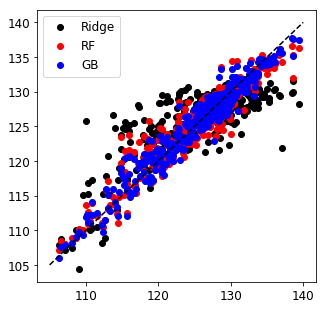

In [137]:
plt.figure(figsize=(5,5))
plt.plot(test_labels, predict[0], 'ko', label="Ridge")
plt.plot(test_labels, predict[2], 'ro', label="RF")
plt.plot(test_labels, predict[3], 'bo', label="GB")
plt.plot([105, 140], [105, 140], 'k--')
#plt.xlabel('P [dB]')
#plt.ylabel('P model [dB]')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc='best', fontsize=12)
plt.savefig('fig4b.png', dpi=300, bbox_inches='tight')
plt.show()

In [138]:
feature_names = X.columns
importances = final_model4.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f+1, feature_names[idx], importances[idx]))

Feature importances:
 1. feature 'Ro   ' (0.1706)
 2. feature 'Stl  ' (0.1471)
 3. feature 'St   ' (0.1417)
 4. feature 'St*rDel' (0.1129)
 5. feature 'Delta' (0.1117)
 6. feature 'Re   ' (0.0900)
 7. feature 'St*Alp' (0.0890)
 8. feature 'Alpha' (0.0855)
 9. feature 'Ma   ' (0.0515)


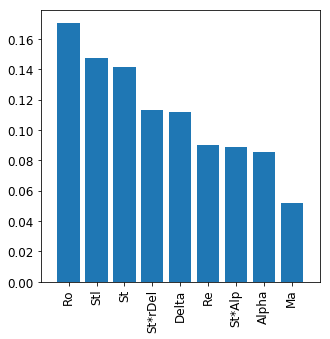

In [140]:
d_first = 9
plt.figure(figsize=(5,5))
#plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('fig5a.png', dpi=300, bbox_inches='tight')

In [141]:
import shap
import xgboost as xgb

shap.initjs()

<Figure size 360x360 with 0 Axes>

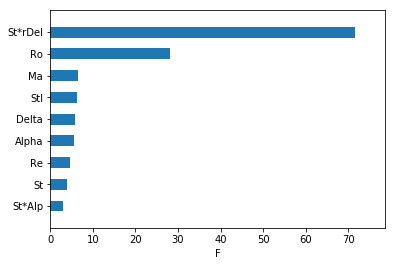

In [142]:
plt.figure(figsize=(5,5))
xgb.plot_importance(final_model4, importance_type='gain', 
                    height=0.5, xlim=None, ylim=None, 
                    xlabel='F', ylabel=None, title=None,
                    max_num_features=None, grid=False, show_values=False)
plt.show()

In [143]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

param = {'max_depth': 9, 'learning_rate': 0.0834, 'colsample_bytree': 0.669, 'gamma': 0.0509, 'min_child_weight': 1.0,
        'reg_alpha': 2.896} 

num_boost_round = 450
model = xgb.train(param, dtrain, num_boost_round)

In [144]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtest) # what dataframe we use 

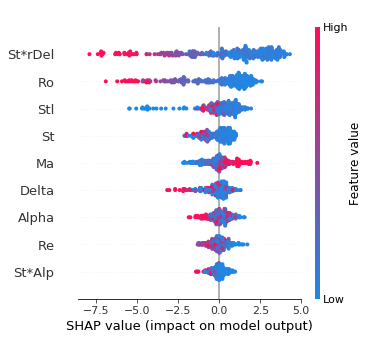

In [147]:
plt.figure(figsize=(5,5))
shap.summary_plot(shap_values,X_test,auto_size_plot=False,plot_type="dot",show=False)
plt.savefig('fig5b.png', dpi=300, bbox_inches='tight')
plt.show()

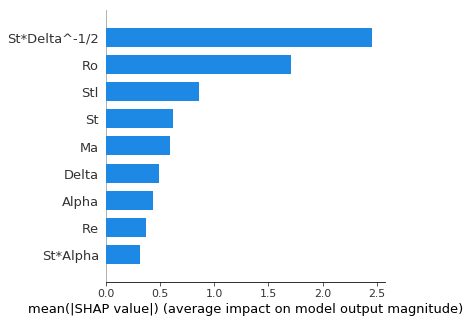

In [89]:
plt.figure(figsize=(5,5))
shap.summary_plot(shap_values, X_test, plot_type="bar",auto_size_plot=False)